In [85]:
# importing required libraries
import pandas as pd
import numpy as np
from isoweek import Week
import matplotlib.pyplot as plt
import datetime
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from dateutil import rrule
from datetime import datetime, timedelta
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing

def CSV(filename):
    return pd.read_csv(filename)    


In [86]:
#first function to import the dataset and out put will be a transformed dataset with 2 columns
def read_data(filename):
    import datetime
    import time
    df = CSV(filename)
    df_t= df.T
    df_t = df_t.reset_index()
    df_t.columns = ['ds', 'y']
    df_t['year']=(df_t['ds'].astype(str).str.slice(stop=4)).astype(int)
    df_t['week']=df_t['ds'].astype(str).str.slice(start=4).astype(int)
    
    def getDateRangeFromWeek(year,week):

        firstdayofweek = datetime.datetime.strptime(f'{year}-W{int(week )- 1}-1', "%Y-W%W-%w").date()
        lastdayofweek = firstdayofweek + datetime.timedelta(days=6.9)
        return firstdayofweek, lastdayofweek

    for i in range(len(df_t)):
    #Call function to get dates range 
        firstdate, lastdate =  getDateRangeFromWeek(df_t['year'][i],df_t['week'][i])
        df_t.loc[i, ['ds']]= lastdate
    
    df_t['ds'] = pd.to_datetime(df_t['ds'], format='%Y-%m')
    df_t=df_t.drop(['year','week'],axis=1)
    
    return df_t 

In [99]:
#HOLTS WINTERS: defining a forcast function to forcast the values of seasonality and trend into another dataframe, 
#here n is also passed for number of extra weeks(here n=7 ie for weeks starting from 2018-03-11 to 2018-04-22)

def predict(data,df_season_trend,n):
    test=pd.DataFrame()
    train=pd.DataFrame()
    
    last_date=data.index[len(data)-1]

    days=n*7
    now = data.index[len(data)-1] + timedelta(7)
    DaysLater = now + timedelta(days)
    
    #forcast for seasonality 
    train['season'] = df_season_trend.season[:last_date]
    test['season'] = df_season_trend.season[now:DaysLater]
    
    #forcast for trend 
    train['trend'] = df_season_trend.trend[:last_date]
    test['trend'] = df_season_trend.trend[now:DaysLater]


    winter_model = ExponentialSmoothing(
        np.asarray(train['season']),
        seasonal_periods=12, trend='add', seasonal='add'
    )
    winter_result = winter_model.fit()
    
    
    winter_model_trend = ExponentialSmoothing(
        np.asarray(train['trend']),
        seasonal_periods=12, trend='add', seasonal='add'
    )
    winter_result_trend = winter_model_trend.fit()
    
    #forcast
    test['season'] = winter_result.forecast(len(test))
    test['trend'] = winter_result_trend.forecast(len(test))
    
    df_season_trend = train.append(test)
    df_season_trend['ds']=df_season_trend.index
    
    return df_season_trend

In [100]:
#function to create 2 separate dataframes one having the residue values and 
#another has the seasonality and trend together
#The forcasted values of the seasonality and trend for extra 7 weeks data is also there.
#the values of the trend for the extra 7 weeks is kept as nan

def create_dataframes(data,n):
   
    data.index=data.ds
    df_residue = pd.DataFrame()
    df_season_trend=pd.DataFrame()

    
    d = []
    new_df_season = pd.DataFrame()
    new_df_res = pd.DataFrame()
    last_date=data.index[len(data)-1]

    days=n*7
    now = data.index[len(data)-1] + timedelta(7)
    DaysLater = now + timedelta(days)

    for dt in rrule.rrule(rrule.WEEKLY, dtstart=now, until=DaysLater):
        d.append(dt)
    
    new_df_season['ds']= pd.to_datetime(d)
    new_df_season['season']=np.nan
    new_df_season['trend']=np.nan
    
    new_df_res['ds']= pd.to_datetime(d)
    new_df_res['y']=np.nan
    
    #extracting the seasonality , trend , residue
    s=sm.tsa.seasonal_decompose(data.y, freq=30)

    df_residue = s.resid.fillna(0)
    df_residue=pd.DataFrame(df_residue,index=df_residue.index)
    df_residue['ds']=df_residue.index
    df_residue = df_residue.append(new_df_res,ignore_index= True)
    df_residue.index=df_residue.ds

    
    df_season_trend['season']=s.seasonal.fillna(0)
    df_season_trend['trend']=s.trend.fillna(0)
    df_season_trend=pd.DataFrame(df_season_trend,index=df_season_trend.index)
    df_season_trend['ds']=df_season_trend.index
    df_season_trend = df_season_trend.append(new_df_season,ignore_index= True)
    df_season_trend.index=df_season_trend.ds
 
    

    df_season_trend=predict(data,df_season_trend,n)
    return df_season_trend,df_residue

In [101]:
data=read_data('sample_org.csv')
df_season_trend,df_residue=create_dataframes(data,6)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [102]:
data.tail()

,ds,y
ds,,
2018-02-04,2018-02-04,17749
2018-02-11,2018-02-11,13842
2018-02-18,2018-02-18,6220
2018-02-25,2018-02-25,4462
2018-03-04,2018-03-04,8741


In [103]:
df_residue.tail(50)

,ds,y
ds,,
2017-05-14,2017-05-14,-631.415500
2017-05-21,2017-05-21,-2943.282167
2017-05-28,2017-05-28,216.376167
2017-06-04,2017-06-04,-1452.861333
2017-06-11,2017-06-11,198.988667
2017-06-18,2017-06-18,-2149.473833
2017-06-25,2017-06-25,1627.797000
2017-07-02,2017-07-02,451.163667
2017-07-09,2017-07-09,64.634500


In [104]:
df_season_trend.tail(20)

,season,trend,ds
ds,,,
2017-12-10,1201.498833,0.000000,2017-12-10
2017-12-17,745.615500,0.000000,2017-12-17
2017-12-24,253.790500,0.000000,2017-12-24
2018-01-07,-83.138667,0.000000,2018-01-07
2018-01-07,405.878000,0.000000,2018-01-07
2018-01-14,381.240500,0.000000,2018-01-14
2018-01-21,-1653.697000,0.000000,2018-01-21
2018-01-28,-44.080333,0.000000,2018-01-28
2018-02-04,404.615500,0.000000,2018-02-04


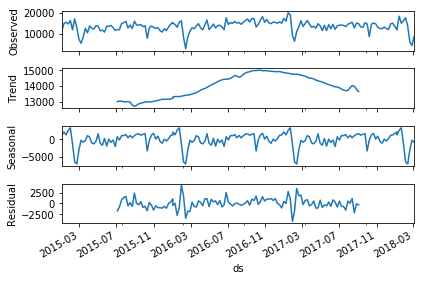

In [98]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data.y, model='additive', filt=None, freq=52)
fig = decomposition.plot()
plt.show()

In [143]:
#RANDOM FOREST
#passed with 2 columns of trend and seasonality to predict the trend nan values 

x = df_season_trend.iloc[:len(data), 0:2].values  
print(x) 
y = df_residue.iloc[:len(data), 1].values 
print(y)

[[ -432.1245         0.        ]
 [  -63.34116667     0.        ]
 [ -359.21366667     0.        ]
 [-1176.28033333     0.        ]
 [ 1201.49883333     0.        ]
 [  745.6155         0.        ]
 [  253.7905         0.        ]
 [  -83.13866667     0.        ]
 [  405.878          0.        ]
 [  381.2405         0.        ]
 [-1653.697          0.        ]
 [  -44.08033333     0.        ]
 [  404.6155         0.        ]
 [ -101.09283333     0.        ]
 [ -252.7095         0.        ]
 [  525.9455     12824.28333333]
 [  204.41216667 12862.35      ]
 [  713.62216667 12805.61666667]
 [  982.25216667 12746.53333333]
 [-1239.6145     12703.73333333]
 [-1526.68783333 12736.65      ]
 [ -167.9745     12724.78333333]
 [  607.74216667 12695.71666667]
 [ 1440.3055     12817.11666667]
 [  507.3655     13057.83333333]
 [-1225.6145     13190.16666667]
 [  986.7255     13186.81666667]
 [  971.28216667 13246.66666667]
 [ -233.32783333 13291.85      ]
 [-1773.3945     13279.91666667]
 [ -432.12

In [149]:
x

array([[ -432.1245    ,     0.        ],
       [  -63.34116667,     0.        ],
       [ -359.21366667,     0.        ],
       [-1176.28033333,     0.        ],
       [ 1201.49883333,     0.        ],
       [  745.6155    ,     0.        ],
       [  253.7905    ,     0.        ],
       [  -83.13866667,     0.        ],
       [  405.878     ,     0.        ],
       [  381.2405    ,     0.        ],
       [-1653.697     ,     0.        ],
       [  -44.08033333,     0.        ],
       [  404.6155    ,     0.        ],
       [ -101.09283333,     0.        ],
       [ -252.7095    ,     0.        ],
       [  525.9455    , 12824.28333333],
       [  204.41216667, 12862.35      ],
       [  713.62216667, 12805.61666667],
       [  982.25216667, 12746.53333333],
       [-1239.6145    , 12703.73333333],
       [-1526.68783333, 12736.65      ],
       [ -167.9745    , 12724.78333333],
       [  607.74216667, 12695.71666667],
       [ 1440.3055    , 12817.11666667],
       [  507.36

In [144]:
# Fitting Random Forest Regression to the dataset 
# import the regressor 
from sklearn.ensemble import RandomForestRegressor 
  
 # create regressor object 
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0) 
  
# fit the regressor with x and y data 
regressor.fit(x, y) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [125]:
range(len(data)+1 , len(df_residue))

range(168, 174)

In [129]:
df_residue.index[168]

Timestamp('2018-03-18 00:00:00')

In [185]:
#predicting the values of the trend for the extra 7 weeks data 

values=[]
pred=df_season_trend[['season','trend']].iloc[len(data) : len(df_residue)]
for i in range(len(pred)):
    y_pred = regressor.predict(np.array([pred.iloc[i]]))
    values.append(y_pred)

In [191]:
# y_pred = regressor.predict
values=[]
pred=df_season_trend[['season','trend']].iloc[len(data) : len(df_residue)]
for i in range(len(data),len(df_residue)):
    y_pred = regressor.predict(np.array([df_season_trend[['season','trend']].iloc[i]]))
    df_residue['y'].iloc[i]=y_pred

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [192]:
df_residue.tail(20)

,ds,y
ds,,
2017-12-10,2017-12-10,0.000000
2017-12-17,2017-12-17,0.000000
2017-12-24,2017-12-24,0.000000
2018-01-07,2018-01-07,0.000000
2018-01-07,2018-01-07,0.000000
2018-01-14,2018-01-14,0.000000
2018-01-21,2018-01-21,0.000000
2018-01-28,2018-01-28,0.000000
2018-02-04,2018-02-04,0.000000


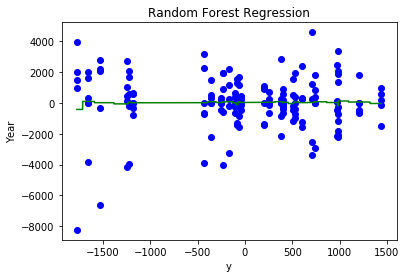

In [117]:
# Visualising the Random Forest Regression results 
# Scatter plot for original data 
plt.scatter(x, y, color = 'blue')   
  
# plot predicted data 
plt.plot(X_grid, regressor.predict(X_grid),  
         color = 'green')  
plt.title('Random Forest Regression') 
plt.xlabel('y') 
plt.ylabel('Year') 
plt.show()



In [194]:
#SVR

x = df_season_trend.iloc[:len(data), 0:2].values  
print(x) 
y = df_residue.iloc[:len(data), 1].values 
print(y)

[[ -432.1245         0.        ]
 [  -63.34116667     0.        ]
 [ -359.21366667     0.        ]
 [-1176.28033333     0.        ]
 [ 1201.49883333     0.        ]
 [  745.6155         0.        ]
 [  253.7905         0.        ]
 [  -83.13866667     0.        ]
 [  405.878          0.        ]
 [  381.2405         0.        ]
 [-1653.697          0.        ]
 [  -44.08033333     0.        ]
 [  404.6155         0.        ]
 [ -101.09283333     0.        ]
 [ -252.7095         0.        ]
 [  525.9455     12824.28333333]
 [  204.41216667 12862.35      ]
 [  713.62216667 12805.61666667]
 [  982.25216667 12746.53333333]
 [-1239.6145     12703.73333333]
 [-1526.68783333 12736.65      ]
 [ -167.9745     12724.78333333]
 [  607.74216667 12695.71666667]
 [ 1440.3055     12817.11666667]
 [  507.3655     13057.83333333]
 [-1225.6145     13190.16666667]
 [  986.7255     13186.81666667]
 [  971.28216667 13246.66666667]
 [ -233.32783333 13291.85      ]
 [-1773.3945     13279.91666667]
 [ -432.12

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()

x= sc_x.fit_transform(x)
y= sc_x.fit_transform(y)

from sklearnearn import SVR
regressor_svr = SVR(kernel = rbf)
regressor_svr.fit(x,y)

In [ ]:
for i in range(len(data)+1 , len(df_residue)):
    y_pred_svr = regressor_svr.predict(df_season_trend.trend[i])
    df_residue.loc[i, ['y']]= y_pred_svr

In [ ]:
# Visualising the Random Forest Regression results 
# Scatter plot for original data 
plt.scatter(x, y, color = 'blue')   
  
# plot predicted data 
plt.plot(X_grid, regressor.predict(X_grid),  
         color = 'red')  
plt.title('SVR') 
plt.xlabel('y') 
plt.ylabel('Year') 
plt.show()